# Topics

- https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6

In [1]:
# from __future__ import print_function, division
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

import random

import _pickle as pickle

from keras_bert import Tokenizer
from keras_bert import load_vocabulary

import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn

from sklearn.manifold import TSNE
import time
import seaborn as sns

    
# %matplotlib inline

Using TensorFlow backend.


In [2]:
%env base openoffice

env: base=openoffice


In [3]:
# https://stackoverflow.com/questions/40115043/no-space-left-on-device-error-while-fitting-sklearn-model
%env JOBLIB_TEMP_FOLDER=/hd/tmp

env: JOBLIB_TEMP_FOLDER=/hd/tmp


In [4]:
MAX_SEQUENCE_LENGTH_T = 20 # 100
MAX_SEQUENCE_LENGTH_D = 20 # 500
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000

In [5]:
# Domain to use
DOMAIN = os.environ['base']
PREPROCESSING = 'bert'
TOKEN = 'bert'
# Dataset paths
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = 'data/normalized/{}/{}.csv'.format(DOMAIN, DOMAIN)

In [6]:
df = pd.read_csv(DATASET)

In [7]:
df.head()

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
0,13,trivial,CLOSED,code,2000-10-16 18:33:00 +0000,2003-12-06 14:52:32 +0000,"I need to see if this works, sorry.",[],P4,Calc,NOT_AN_ISSUE,Test bug: Cell color is wrong,605
1,14,trivial,CLOSED,Website general issues,2000-10-17 19:40:00 +0000,2006-02-07 22:23:55 +0000,it would be nice if the combination of OpenOff...,[],P3,Infrastructure,FIXED,openoffice.org issuezillla URL's display a hor...,current
2,15,trivial,CLOSED,Bugzilla,2000-10-19 11:49:00 +0000,2003-12-27 10:23:17 +0000,this task is just a test\nthis task is just at...,[],P5,Infrastructure,FIXED,test task,current
3,16,trivial,CLOSED,_openoffice.org administrative interface (obso...,2000-10-20 15:06:00 +0000,2003-12-06 14:52:32 +0000,Using the ADMIN link on the main page leads to...,[],P1,Infrastructure,FIXED,Administrative Interface not available,current
4,17,trivial,CLOSED,_openoffice.org CVS (obsolete),2000-10-20 18:46:00 +0000,2003-12-06 14:52:32 +0000,Entered into Issuezilla for tracking purposes....,[],P3,Infrastructure,FIXED,update modules file.,current


In [8]:
df_textual = df[['bug_id', 'short_desc', 'description']]
df_textual.loc[:, 'text'] = df['short_desc'] + ". " + df['description']
df_textual.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,bug_id,short_desc,description,text
0,13,Test bug: Cell color is wrong,"I need to see if this works, sorry.",Test bug: Cell color is wrong. I need to see i...
1,14,openoffice.org issuezillla URL's display a hor...,it would be nice if the combination of OpenOff...,openoffice.org issuezillla URL's display a hor...
2,15,test task,this task is just a test\nthis task is just at...,test task. this task is just a test\nthis task...
3,16,Administrative Interface not available,Using the ADMIN link on the main page leads to...,Administrative Interface not available. Using ...
4,17,update modules file.,Entered into Issuezilla for tracking purposes....,update modules file.. Entered into Issuezilla ...


In [9]:
data = df_textual['text'].values

In [10]:
print("Total of data ", len(data))

Total of data  98070


In [11]:
data[:-2]

array(['Test bug: Cell color is wrong. I need to see if this works, sorry.',
       'openoffice.org issuezillla URL\'s display a horribly ugly heading gif.. it would be nice if the combination of OpenOffice.org gif and "IssueZilla:" \ntext could be artfully combined with better matching alignment, color and font.\nI tried playing with vertical alignment and it didn\'t help. \nIt seemed bogus to spend much time trying to align the OOo gif with the text\nsince it would still look bad anyways in some other browser.\n\nI\'m hoping to get some graphics assistance to make this look better.\n\nNote, see http://www.openoffice.org/issues/editparams.cgi \'bannerhtml\'\nand \'blurbhtml\' parameters for where this information is set. It\'s not like we\ncan\'t easily set the HTML different, so anybody has a suggestion for',
       'test task. this task is just a test\nthis task is just athis task is just a test\n test\nathisathistthis task is just a test\nthis task is just athis task is just a test

## Bert tokens 

In [12]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')
token_dict = load_vocabulary(vocab_path)
tokenizer = Tokenizer(token_dict)

### Load bugs

In [13]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D,
                   token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [14]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

In [15]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


98070

In [16]:
%%time

experiment.load_bugs(TOKEN)
len(baseline.sentence_dict)


CPU times: user 10 s, sys: 1.4 s, total: 11.4 s
Wall time: 11.9 s


In [17]:
ids = []
data = []
for bug_id in tqdm(baseline.bug_set):
    bug = baseline.bug_set[bug_id]
    ids.append(bug_id)
    title = bug['title']
    desc = bug['description']
    data.append("{}\n{}\n".format(title, desc))

In [18]:
# Normalize minutes
# data = [re.sub(r'[0-9]{1,} (min|minutes|minute|m)', 'x time', str(sent)) for sent in data]
# Normalize dates
# data = [re.sub(r'(\d+/\d+/\d+)', 'date', str(sent)) for sent in data]
# Normalize hours
# data = [re.sub(r'(\d+:\d+:\d+)', 'hour', sent) for sent in data]
data = [re.sub(r'(SEP|CLS)', ' ', sent) for sent in data]
# Remove ponctuation
data = [re.sub(r'\W+', ' ', sent) for sent in data]
# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]

In [19]:
data[:2]

[' test bug cell color is wrong i need to see if this works sorry ',
 ' open off ice org issue zi ll la ur l s display a horribly ugly heading gi f it would be nice if the combination of open off ice org gi f and issue zi lla text could be art fully combined with better matching alignment color and font i tried playing with vertical alignment and it didn t help it seemed bog us to spend much time trying to align the o oo gi f with the text since it would still look bad anyway s in some other browser i m hoping to get some graphics assistance to make this look better note see http www open off ice org issues edit para ms c gi banner ht ml and blur bh tm l parameters for where this information is set it s not like we can t easily set the html different so anybody has a suggestion for ']

### Tokenization

In [20]:
%%time

def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])


[['test', 'bug', 'cell', 'color', 'is', 'wrong', 'need', 'to', 'see', 'if', 'this', 'works', 'sorry']]
CPU times: user 24.4 s, sys: 281 ms, total: 24.7 s
Wall time: 24.6 s


### Lemmatization

In [21]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent[:100000])) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [22]:
%%time

# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])


['test bug cell color be need see work', 'open ice org issue zi display head gi would be combination ice org gi issue zi lla text could be art combine match alignment color font try play alignment help seem bog spend time try align gi text would look browser hope get graphic assistance make look note see http www open ice org issue edit para gi banner ml blur bh parameter information be set can set html anybody have suggestion']
CPU times: user 5min 10s, sys: 3.04 s, total: 5min 13s
Wall time: 5min 12s


## Create the Document-Word matrix

In [23]:
%%time

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10, # minimum reqd occurences of a word 
                             stop_words='english', # remove stop words
                             lowercase=True, # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3
                             # max_features=50000,  # max number of uniq words    
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

CPU times: user 2.94 s, sys: 0 ns, total: 2.94 s
Wall time: 2.94 s


### Selecting best model 

In [24]:
%%time

# Define Search Param
search_params = {'n_components': [10, 20, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0, n_jobs=-1)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)

CPU times: user 16min 6s, sys: 2min 17s, total: 18min 23s
Wall time: 59min 4s


In [25]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'n_components': 30, 'learning_decay': 0.9}
Best Log Likelihood Score:  -9798547.322913293
Model Perplexity:  493.85507244009455


### Dominant topics

In [26]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0,0,0,0,0,0,0,0,0.17,0,0,0,0.13,0,0.16,0,0,0,0,0,0.27,0,0,0,0.16,0,0,0,0,0,20
Doc1,0,0,0,0,0,0,0,0.04,0,0,0,0,0,0,0.19,0,0,0.13,0,0,0.23,0,0,0.03,0,0,0,0.18,0,0.18,20
Doc2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.48,0,0,0,0,0,0.48,0,0,0,0,0,0,0,0.02,0,14
Doc3,0,0,0.2,0,0,0,0,0,0,0,0,0,0,0,0.07,0.07,0.08,0,0,0,0.14,0.08,0,0,0,0,0,0,0,0.31,29
Doc4,0,0.14,0,0,0,0,0.04,0,0,0,0.05,0.02,0,0,0,0,0.09,0,0,0.3,0.11,0,0.12,0.09,0,0,0,0,0,0.02,19
Doc5,0,0,0,0,0,0,0,0,0,0.19,0,0,0,0,0,0,0,0.12,0,0,0.5,0,0,0,0,0,0,0,0,0.11,20
Doc6,0.16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,0,0,0,0,0,0,0,0,0.63,0,0,27
Doc7,0,0,0,0,0,0.39,0,0,0,0,0,0,0.17,0,0,0,0.11,0,0,0,0.28,0,0,0,0,0,0,0,0,0,5
Doc8,0,0.1,0,0.21,0,0.06,0,0,0.23,0.15,0,0,0,0,0,0,0,0,0,0,0,0.05,0,0.16,0,0,0,0,0,0,8
Doc9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0,0,0.71,0,0,0,0.12,0,0,0,0,0,20


### Key words topics

In [27]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords

,aaa,aachen,aan,aba,abandon,abbreviate,abbreviation,abc,abe,abi,...,zon,zone,zong,zoo,zoom,zulu,zur,zza,zzle,zzo
Topic0,0.033696,0.034404,0.033870,0.033765,0.033800,0.033655,130.278407,0.033686,0.034162,0.033643,...,0.033660,0.079350,0.033648,0.033754,0.034033,0.033688,0.033622,0.033724,0.033678,0.033625
Topic1,0.033615,0.034230,0.034374,2.328672,0.033649,0.033640,0.033690,0.033679,0.033631,0.033622,...,0.033631,0.033704,0.033641,0.033664,0.033637,0.033656,0.033634,0.033650,0.033644,0.033658
Topic2,0.033692,0.033764,0.033610,0.033841,0.034339,0.033888,0.042655,375.601570,0.033679,0.033635,...,0.034737,0.033632,0.074060,0.033691,0.033667,0.033636,0.033639,0.033709,0.043718,0.033647
Topic3,0.033650,0.038401,0.033692,19.119121,33.319732,0.036123,0.033620,0.038132,0.034980,0.034244,...,0.033638,33.438900,0.033627,0.033660,0.033730,0.033631,0.033712,0.035178,0.040317,0.034719
Topic4,0.033674,0.034889,0.033652,0.034675,0.038942,0.033755,0.033633,0.034145,0.033643,0.033611,...,0.154557,0.033722,52.245912,0.038744,0.039935,0.033601,0.033704,0.033576,0.033630,0.035619
Topic5,0.033741,0.033633,0.034448,10.502088,0.033801,0.033606,0.033701,0.036732,0.033758,0.033652,...,0.034160,0.033635,0.033612,0.033590,0.033585,0.033631,0.034004,0.034353,0.033614,0.033629
Topic6,0.033613,0.033652,0.033628,0.033986,6.499096,18.295628,0.034917,0.034441,0.033662,0.033669,...,0.033609,0.040532,0.033609,0.033628,0.033755,0.033631,0.033627,0.033765,0.034114,0.072811
Topic7,0.033627,0.033635,0.033632,0.033701,0.033632,0.033604,0.033622,0.033825,0.033852,0.033683,...,0.053993,0.033704,0.033667,0.034968,0.033657,0.033638,0.035415,0.033630,0.034596,0.033626
Topic8,0.033636,0.033616,0.033641,0.033725,0.033646,0.034334,0.033655,0.034207,0.047689,1.156076,...,0.033631,0.033578,0.035229,0.033635,0.034185,0.033706,0.033610,0.033703,0.033638,0.033633
Topic9,0.033670,0.035803,0.034973,0.034195,0.033787,0.033690,0.033553,0.034559,0.033768,0.033679,...,0.039572,0.034245,0.041447,0.033632,0.033649,0.061172,0.033604,0.038040,0.034604,18.677478


### Get the top 15 words by topic

In [28]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=None, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,number,sum,dina,beta,child,bundle,eta,unit,smoke,auto,ruler,currency,cent,dimension,iteration
Topic 1,build,source,mac,ink,update,aqua,drive,make,tar,dev,pavel,win,solve,volume,def
Topic 2,string,template,setting,sub,case,default,remove,letter,use,hide,assign,ref,connection,define,update
Topic 3,install,user,error,file,run,crash,office,try,use,message,installation,instal,problem,work,start
Topic 4,view,chart,sheet,datum,record,macro,label,bit,range,data,change,count,regression,axis,edit
Topic 5,framework,int,library,home,thread,sal,script,core,yst,app,warning,set,warn,mac,tion
Topic 6,value,include,column,row,date,filter,datum,table,auto,pace,function,lter,sort,col,return
Topic 7,graphic,sample,ding,cha,uate,bed,iso,video,vista,ring,pic,ree,art,card,encode
Topic 8,line,export,slide,point,presentation,impress,title,use,master,background,color,bullet,set,border,rec
Topic 9,copy,patch,paste,translation,attach,work,access,thank,key,guide,make,clip,board,man,need


## Save topics for each bug

In [29]:
X = np.array([row[:-1] for row in df_document_topic.values])
y = np.array([row[-1] for row in df_document_topic.values])
classes = np.unique(y)
X.shape, y.shape, classes.shape, np.asarray(ids).shape

((98070, 30), (98070,), (30,), (98070,))

In [30]:
for i in tqdm(range(len(ids))):
    filename = 'bugs/{}.pkl'.format(ids[i])
    try:
        with open(os.path.join(DIR, filename), 'rb') as f:
            bug = pickle.load(f)
            # Update bugs with topics
            bug['topics'] = X[i]
            bug['topic'] = int(y[i])
            bug['topic_index'] = int(y[i]) - 1
    except:
        bug = {}
    if('topic' not in bug):
        print("Bug of index {} was not saved".format(i))
        continue
    bug_dir = os.path.join(DIR, 'bugs')
    with open(os.path.join(bug_dir, str(ids[i]) + '.pkl'), 'wb') as f:
        pickle.dump(bug, f)

### Visualize topics embed space

In [31]:
def create_tsne(X):
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return tsne_results

In [32]:
def plot_clusters(y, tsne_results, classes):
    df_subset = {}
    df_subset['y'] = y
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", len(classes)),
        data=df_subset,
        legend="full",
        alpha=0.8
    )

In [33]:
X_tsne = X[:1000]
y_tsne = y[:1000]
classes = np.unique(y_tsne)

In [34]:
tsne_results = create_tsne(X_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.006s...
[t-SNE] Computed neighbors for 1000 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.185603
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.241478
[t-SNE] Error after 300 iterations: 1.010023
t-SNE done! Time elapsed: 5.124763488769531 seconds


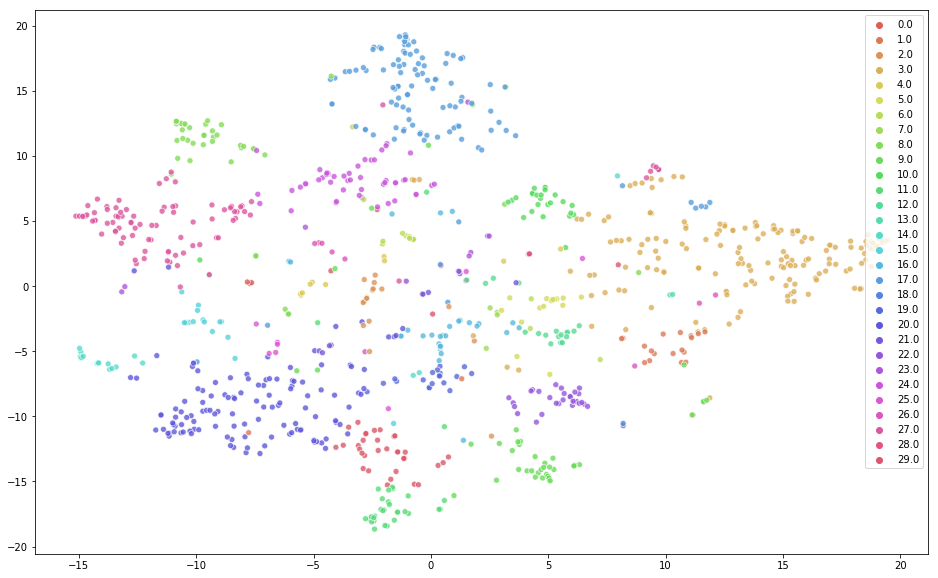

In [35]:
plot_clusters(y_tsne, tsne_results, classes)